# Use PmagPy functions for analysis of paleomagnetic data
Modified from original Magic-Supplied notebook to read files directly from the web.
SMR 2019-06-06

#  Before you begin

You may be viewing this notebook as a rendered html webpage (which can be seen at this link: http://pmagpy.github.io/Example_PmagPy_Notebook.html) or PDF in which case you can go ahead and simply have a look at it. However, if you wish to execute the code within a downloaded version of this notebook (which can be found here: https://github.com/PmagPy/2016_Tauxe-et-al_PmagPy_Notebooks), it is necessary to have an installed distribution of Python and to have installed the PmagPy software distribution. The instructions in the PmagPy Cookbook can help get you started in this regard:

http://earthref.org/PmagPy/cookbook

The user may also benefit from perusing the 'Survival computer skills' and 'Introduction to Python Programming' chapters of the cookbook if they are new to programming in Python.

#  Introduction

This notebook is based on a notebook created by Nicholas Swanson-Hysell, Lisa Tauxe and Luke Fairchild that accompanied a paper entitled: 

**PmagPy: Software package for paleomagnetic data analysis and a bridge to the Magnetics Information Consortium (MagIC) Database**
*L. Tauxe, R. Shaar, L. Jonestrask, N.L. Swanson-Hysell, R. Minnett, A.A.P., Koppers, C.G. Constable, N. Jarboe, K. Gaastra, and L. Fairchild*

The analysis in this notebook uses data accessed using the MAGic contribution number.

In this notebook, we will use PmagPy to:

* Unpack data downloaded from the MagIC database.
* Plot directions and VGPs.
* Calculate and plot Fisher means for directions and VGPs.
* Conduct a bootstrap fold test on the data.
* Conduct a common mean test between the data from the two contributions.

# Import necessary function libraries for data analysis

This Jupyter notebook works using a Python 3.4 kernel. The code block below imports the pmagpy module from PmagPy that provides functions that will be used in the data analysis. At present, the most straight-forward way to do so is to install the pmagpy module using the pip package manager by executing this command at the command line:

```pip install pmagpy```

Approachs not using pip can also work. One way would be to download the pmagpy folder from the main PmagPy repository and either put it in the same directory as the notebook or put it anywhere on your local machine and add a statement such as ```export PYTHONPATH=$PYTHONPATH:~/PmagPy``` in your .profile or .bash_profile file that points to where PmagPy is on your local machine (in this example in the home directory). 

With PmagPy available in this way, the function modules from **PmagPy** can be imported:  **pmag**, a module with ~160 (and growing) functions for analyzing paleomagnetic and rock magnetic data and  **ipmag**, a module with functions that combine and extend **pmag** functions and exposes **pmagplotlib** functions in order to generate output that works well within the Jupyter notebook environment. 

To execute the code, click on play button in the menu bar, choose run under the 'cell' menu at the top of the notebook, or type shift+enter.

In [ ]:
#  If the imports in the next cell don't work, uncomment this pip command and run it
#!pip install pmagpy


In [ ]:
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag

There are three other important Python libraries (which are bundled with the Canopy and Anaconda installations of Python) that come in quite handy and are used within this notebook:  **numpy** for data analysis using arrays, **pandas** for data manipulation within dataframes and **matplotlib** for plotting. The call ```%matplotlib inline``` results in the plots being shown within this notebook rather than coming up in external windows. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}
#
# this is a python file (MagicToDataFrames.py) that needs to be in the same directory
#  as this ipython notebook file. It contains modified routines from pmag and ipmag to
#  load from a magic database file to a dictionary of pandas dataframes.
import MagicToDataFrames

In [18]:
%%javascript
function getQueryStringValue (key)
{  
    return unescape(window.location.search.replace(new RegExp("^(?:.*[&\\?]" + escape(key).replace(/[\.\+\*]/g, "\\$&") + "(?:\\=([^&]*))?)?.*$", "i"), "$1"));
}
IPython.notebook.kernel.execute("documentID='".concat(getQueryStringValue("documentId")).concat("'"));
IPython.notebook.kernel.execute("user='".concat(getQueryStringValue("user")).concat("'"));
IPython.notebook.kernel.execute("full_notebook_url='" + window.location + "'"); 

<IPython.core.display.Javascript object>

# Import data into the notebook

## Unpack files downloaded from the MagIC database

Data within the MagIC database can be downloaded as a single .txt file. This file is then split into its constituent EarthRef and pmag tables in separate pandas dataframes, using a modified version of the function **ipmag.download_magic**. Each dataframe is named for the tab section of the MagIC databaset text file that was downloaded. The pandas dataframes are then used for subsequent data analysis. The ```%%capture``` line blocks annoying messages printed by the **ipmag.download_magic** function.  

SMR 2019-06-06
the original notebook loaded files from the local file system. 
The ipmag.download_from_magic function has been modified to get the whole file, and then pass the file-like object to a modified ipmag.download_magic, which generates a pandas frame for each tab section of the Magic database file. Keep all in memory for now so don't have to deal with permissions to write to the file system.

In [19]:
#%%capture
print('Input document id: ' + documentID)


#outputdict = MagicToDataFrames.download_from_magic(11087)
outputdict = MagicToDataFrames.download_from_magic(documentID)

Input document id: 13267
CALL magicToDataframe
data table: contribution; 1 records
data table: locations; 4 records
data table: sites; 120 records
contributor: @polarwand;  reference: 10.1139/e74-113


## Loading the unpacked data into Pandas Dataframes

With the results unpacked from MagIC, the data can now be analyzed within the notebook. The data from the pmag_sites frame are used to look at the directions from each site. A nice way to deal with data within Python is using the dataframe structure of the pandas package. The code block below uses the pd.read_csv function to create a dataframe from the pmag_sites.txt file. All MagIC formatted files are tab delimited (```sep='\t'```) with two header lines, one with the type of delimiter and MagIC table and one with the MagIC database column names. To see the formats for MagIC tables, go to http://earthref.org/MAGIC/metadata.htm.
To skip the first header line in a particular file when importing it to a DataFrame, set skiprows=1.  The ```data_frame_name.head(X)``` function allows us to inspect the first ```X``` rows of the dataframe (in this case 4).

In [20]:
#print(outputdict)
thekeys=(list(outputdict))
if 'pmag_sites' in thekeys:
    theSites = outputdict['pmag_sites']
else:
    print('No sites to work with, sorry')

No sites to work with, sorry


## Filtering by polarity and tilt-correction

Let's start our analysis on the reversed polarity sites that are below an angular unconformity in the Halls (1974) data set. A nice thing about dataframes is that there is built-in functionality to filter them based on column values. The code block below creates a new dataframe of sites that have the site_polarity value of 'r' in the pmag_sites table. It then creates one dataframe for tilt-corrected sites (value of 100 in site_tilt_correction) and sites that have not been tilt-corrected (value of 0 in site_tilt_correction).

In [7]:
#replace .ix with .loc in this part
theSites_r = theSites.loc[theSites.site_polarity=='r']
#print("TiltCorrection r:",theSites_r.site_tilt_correction)
# all the numbers in the dataframe are objects, os have to treat as strings
theSites_r_tc = theSites_r.loc[theSites_r.site_tilt_correction=='100']
#print("r_tc:", theSites_r_tc)
theSites_r_tc.reset_index(inplace=True)
theSites_r_is = theSites_r.loc[theSites_r.site_tilt_correction=='0']
theSites_r_is.reset_index(inplace=True)


#example code to treat a series in the dataframe as numbers
#pd.to_numeric(theSites_r_is.site_inc,errors='ignore').tolist()



# Data analysis and visualization

The data can be analyzed and visualized using PmagPy functions. We will first create a directory called 'Example_Notebook_Output'  from within the notebook (using the initial ! before the command invokes a command as if typed on the command line from within a notebook) so that we have a place to put saved figures.  You can do this outside of the notebook if you prefer.   

## Calculating Fisher means

Fisher means for the data can be calculated with the function **ipmag.fisher_mean**. This function takes in a list of declination values, a list of inclination values and returns a dictionary that gives the Fisher mean and associated statistical parameters. This dictionary is printed out for the mean of the tilt-corrected data within the first code block. These dictionary objects are given names such that we can subsequently access the values. The second code block uses the **ipmag.print_direction_mean** to print out a formatted version of these same results.

In [8]:
Site_r_is_mean = ipmag.fisher_mean(pd.to_numeric(theSites_r_is.site_dec,errors='ignore').tolist(),
                                       pd.to_numeric(theSites_r_is.site_inc,errors='ignore').tolist())
Site_r_tc_mean = ipmag.fisher_mean(pd.to_numeric(theSites_r_tc.site_dec,errors='ignore').tolist(),
                                        pd.to_numeric(theSites_r_tc.site_inc,errors='ignore').tolist())
#print(Site_r_tc_mean)
#print(theSites_r_is)

In [9]:
print('The mean for the tilt-corrected directions is:')
ipmag.print_direction_mean(Site_r_tc_mean)

The mean for the tilt-corrected directions is:
Dec: 115.0  Inc: -57.6
Number of directions in mean (n): 25
Angular radius of 95% confidence (a_95): 4.6
Precision parameter (k) estimate: 40.2


## Plotting the Site results

The code block below creates a figure with an equal area stereonet and uses the **ipmag.plot_di** function to plot the data both in tilt-corrected and *in situ* coordinates. The figure can be saved out of the notebook using the ```plt.savefig()``` function. The saved figure file type can be .png, .eps, .svg among others. Saved figures can be used as is for publication or, if necessary, exported vector graphics (e.g. .eps and .svg files) can be edited with software such as Adobe Illustrator or Inkscape.  

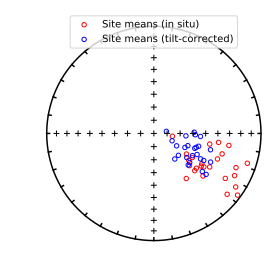

In [10]:
plt.figure(num=1,figsize=(4,4))
ipmag.plot_net(fignum=1)
ipmag.plot_di(pd.to_numeric(theSites_r_is.site_dec,errors='ignore').tolist(),
              pd.to_numeric(theSites_r_is.site_inc,errors='ignore').tolist(),color='r',
              label='Site means (in situ)')
ipmag.plot_di(pd.to_numeric(theSites_r_tc.site_dec,errors='ignore').tolist(),
              pd.to_numeric(theSites_r_tc.site_inc,errors='ignore').tolist(),color='b',
             label='Site means (tilt-corrected)')
plt.legend(loc=9)
#plt.savefig('Example_Notebook_Output/theSites.svg')

A similar plot showing the Fisher means of the site means calculated above and their associated $\alpha_{95}$ confidence ellipses can be generated using the **ipmag.plot_di_mean** function.

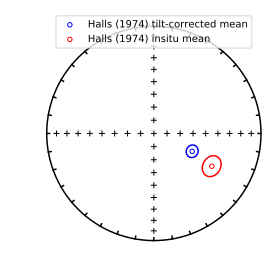

In [12]:
plt.figure(num=1,figsize=(4,4))
ipmag.plot_net(fignum=1)
ipmag.plot_di_mean(Site_r_tc_mean['dec'],
                   Site_r_tc_mean['inc'],
                   Site_r_tc_mean['alpha95'],'b',
                   label='Halls (1974) tilt-corrected mean')
ipmag.plot_di_mean(Site_r_is_mean['dec'],
                   Site_r_is_mean['inc'],
                   Site_r_is_mean['alpha95'],'r',
                   label='Halls (1974) insitu mean')
plt.legend(loc=9)
#plt.savefig('Example_Notebook_Output/Halls_1974_means.svg')

The means that have been calculated are now dictionaries that can be made into a new dataframe to present the results. A table like this can be exported into a variety of formats (e.g. LaTeX, html, csv) for inclusion in a publication.

In [13]:
Site_r_is_mean = ipmag.fisher_mean(pd.to_numeric(theSites_r_is.site_dec,errors='ignore').tolist(),
                                       pd.to_numeric(theSites_r_is.site_inc,errors='ignore').tolist())
Site_r_tc_mean = ipmag.fisher_mean(pd.to_numeric(theSites_r_tc.site_dec,errors='ignore').tolist(),
                                        pd.to_numeric(theSites_r_tc.site_inc,errors='ignore').tolist())
means = pd.DataFrame([Site_r_is_mean,Site_r_tc_mean],
                     index=['Site_insitu)','Site_tilt-corrected)'])
means

,alpha95,csd,dec,inc,k,n,r
Site_insitu),7.429483,20.147915,119.491601,-37.834483,16.162548,25,23.515086
Site_tilt-corrected),4.624479,12.780983,114.967445,-57.572956,40.164420,25,24.402456


Alternatively, one can export the MagIC data table pmag_results.txt into a tab delimited or latex file using the PmagPy program: **pmag_results_extract.py** which can be run at the command line as:
```
pmag_results_extract.py -f project/pmag_results.txt
```
```
pmag_results_extract.py -f project/pmag_results.txt -tex
```
or executed as shell command within the notebook by using the ! prefix as is done in the cell block below.

In [14]:
# !pmag_results_extract.py -f {local path here}/pmag_results.txt

# Concluding thoughts

This notebook is intended to be an illustrative case study of simple data analysis that can be accomplished using PmagPy within a Jupyter notebook. All the capabilities of PmagPy can be utilized within notebooks, although continued work is needed for the functionality within some of the command line programs to be made into functions that work well within the environment.

An advantage of this type of workflow is that it is well-documented and reproducible. The decisions that went into the data analysis and the implementation of the statistical tests are fully transparent (as is the underlying code). Additionally, if one were to seek to add more data to the mean pole, all of the data analysis could be quickly redone by executing all of the code in the notebook.

Smaller snippets of code that demonstrate additional PmagPy functionality within the notebook environment can be seen in this notebook: 

http://pmagpy.github.io/Additional_PmagPy_Examples.html


# Works cited


Tauxe, L. with contributions from Subir K. Banerjee, Robert F. Butler and Rob van der Voo, Essentials of Paleomagnetism, Univ. California Press, 2010.  Current online version:  https://earthref.org/MagIC/books/Tauxe/Essentials/